# Homework 4

In [1]:
import cvxpy as cp
import numpy as np
from scipy.linalg import expm, norm
from scipy.stats import norm as norm_dist
import matplotlib.pyplot as plt

## Question 1

### (a) A One‐Parameter Stressing Method for an Equicorrelation Matrix

An equicorrelation matrix for $n$ assets has the form $C = (1-\rho)I_n + \rho\, J_n$, where $I_n$ is the identity, 
$J_n$ is an $n\times n$ matrix of ones, and $\rho$ is the common off‐diagonal correlation. 
A key property is that to be a valid correlation matrix, one must have 
$$\rho \in \left[-\frac{1}{n-1},1\right]$$

A simple “stress” method is to introduce a single parameter $\theta\in[-1,1]$ and map it linearly into the admissible range for $\rho$. For example, define
$$
\rho(\theta)=\left(\frac{1+\theta}{2}\right)\left(1+\frac{1}{N-1}\right)-\frac{1}{N-1}.
$$
In this mapping:
- When $\theta=-1$, $\rho(-1)=-1/(N-1)$ (the minimum allowable value).
- When $\theta=1$, $\rho(1)=1$.

The stressed correlation matrix is then given by
$$C(\theta) = (1-\rho(\theta))I_n + \rho(\theta)\, J_n$$

This method is appealing because it depends on just a single parameter, and the resulting matrix is still a valid correlation matrix by construction. Moreover, the same idea extends directly to Gaussian or t copula models since you would simply plug the stressed $ C(\theta) $ into the copula’s dependence structure while keeping marginal distributions unchanged.

**Using This Stress to Estimate Derivative Sensitivity:**  
Once you have such a stressed matrix:
1. Base Valuation: Start by pricing your derivative instrument using the “base” correlation (say, corresponding to $\theta=0$).
2. Stress Testing: Reprice the derivative for a range of $\theta$ values (e.g., $\theta$ shifted slightly up and down from 0). In a copula model (Gaussian or $t$), the stressed $C(\theta)$ is used to generate joint scenarios.
3. Sensitivity Estimation: Compute the sensitivity by approximating the derivative of the instrument’s price $P$ with respect to $\theta$ (or indirectly with respect to $\rho$). For example, a finite difference estimate could be:
   $$
   \frac{\partial P}{\partial\theta}\approx \frac{P(\theta+\Delta\theta)-P(\theta-\Delta\theta)}{2\Delta\theta}.
   $$
This procedure tells you how the derivative’s price responds to changes in correlation.

### (b) The Archakov–Hansen Parametrization Algorithm

In [2]:
# Archakov–Hansen correlation matrix construction
def archakov_hansen_corr(A_off, tol=1e-6, max_iter=1000):
    """
    Given an n x n symmetric matrix A_off containing the off-diagonal elements,
    this function finds a vector x (diagonals) such that if A = A_off + diag(x),
    then C = expm(A) is a correlation matrix (i.e. diag(C) = 1).
    
    Parameters:
        A_off : np.ndarray (n x n)
            A symmetric matrix with zeros on the diagonal (or preset off-diagonals).
        tol : float
            Convergence tolerance.
        max_iter : int
            Maximum number of iterations.
    
    Returns:
        C : np.ndarray (n x n)
            The correlation matrix.
    """
    n = A_off.shape[0]
    x = np.zeros(n)  # initial guess for diagonal adjustments
    for it in range(max_iter):
        A = A_off + np.diag(x)
        expA = expm(A)
        diag_expA = np.diag(expA)
        # Update x to enforce diag(expA)==1: x_new = x - log(diag(expA))
        x_new = x - np.log(diag_expA)
        if np.linalg.norm(x_new - x) < tol:
            x = x_new
            break
        x = x_new
    # Compute final correlation matrix
    A_final = A_off + np.diag(x)
    C = expm(A_final)
    return C


**Estimating Sensitivities of a Derivative to \(d\)**

Assuming you have an estimate for the off-diagonal vector $d$ (or you treat it as your “base” parameterization for the log‐correlation), you can assess the sensitivity of a derivative instrument as follows:

1. Baseline Price: Compute the derivative price using the base correlation matrix $C$ (obtained from your current $d$ via the Archakov–Hansen algorithm).

2. Perturbation: Slightly perturb one or several elements of $d$ (or a direction in the space of $d$). For example, for each component $d_i$ compute $d_i^\epsilon = d_i + \epsilon$ while keeping other elements constant.

3. Recompute $C$ and Price: For each perturbed $d\$ recompute the correlation matrix using the algorithm, then reprice the derivative instrument.

4. Finite Differences: Estimate the sensitivity (or “Greek”) with respect to each component of $d$ by a finite difference approximation:
   $$
   \frac{\partial P}{\partial d_i} \approx \frac{P(d_i+\epsilon)-P(d_i)}{\epsilon}.
   $$

This procedure quantifies how small changes in the “low” off-diagonal entries (and thus in the implied log‐correlation) affect the derivative’s price.

## Question 2

First let's restate subadditivity and positive homogeneity. 

A risk measure $\rho$ is subadditive if for all positions (or losses) $L_1,L_2$ in the domain $\mathcal{M}$ we have $\rho(L_1+L_2) \le \rho(L_1) + \rho(L_2)$.

A risk measure $\rho$ is positively homogeneous if for every position $L$ in $\mathcal{M}$ and every scalar $\lambda \ge 0$ we have $\rho(\lambda L) = \lambda\,\rho(L)$.

Monotonicity axiom is stated as follows. If $L_1,L_2\in\mathcal{M}$ satisfy $L_1 \ge L_2 \quad$ then $\rho(L_1) \ge \rho(L_2)$.

The assumption we can make is that $L\le 0$ we have $\rho(L)\le 0$. We want to show that if $L_1$ and $L_2$ are two positions with
$L_1 \ge L_2$, then it must be that $\rho(L_1) \ge \rho(L_2)$.

Define the difference $M := L_1 - L_2$. Since $_1 \ge L_2$, it follows that $M \ge 0$. Equivalently, $-M \le 0$. By our assumption, we then have
$\rho(-M) \le 0$. 

Now, express $L_2$ as $L_2 = L_1 - M$. Using the subadditivity property of $\rho$, we get $\rho(L_2)=\rho(L_1 - M) \le \rho(L_1) + \rho(-M)$.

Since $\rho(-M)\le 0$, it follows that $\rho(L_2) \le \rho(L_1)$.

This is exactly the monotonicity property (a larger risk measure corresponds to a riskier position).

## Question 3

In [3]:
def construct_A_off(n, rho_p, rho_n):
    """
    Construct an n x n matrix of off-diagonals for use in the Archakov–Hansen algorithm.
    We assume:
      - Securities 0,1,2 (first three) have target positive correlation rho_p.
      - Security 3 has zero correlation with securities 0,1,2.
      - Security 4 (last one) has target negative correlation rho_n with securities 0,1,2 and security 3.
      
    The hints suggest using:
      gamma_p = - (1/n)*log((1 - rho_p)/(1 + rho_p*(n-1)))
      gamma_n = - (1/n)*log((1 - rho_n)/(1 + rho_n*(n-1)))   # note the minus sign here for negative correlation
    Parameters:
        n : int
            Dimension (here, 5).
        rho_p : float
            Target positive correlation (> 0).
        rho_n : float
            Target negative correlation (< 0).
    
    Returns:
        A_off : np.ndarray (n x n)
            Symmetric matrix with the prescribed off-diagonals.
    """
    A_off = np.zeros((n, n))
    gamma_p = - (1/n)*np.log((1 - rho_p) / (1 + rho_p*(n-1)))
    gamma_n = - (1/n)*np.log((1 - rho_n) / (1 + rho_n*(n-1)))  # corrected: negative sign
    
    for i in range(n):
        for j in range(i+1, n):
            # Securities 0,1,2 (first three) have positive correlation among themselves.
            if i in [0, 1, 2] and j in [0, 1, 2]:
                A_off[i, j] = gamma_p
            # Security 3 (index 3) has zero correlation with securities 0,1,2.
            elif (i in [0, 1, 2] and j == 3) or (i == 3 and j in [0, 1, 2]):
                A_off[i, j] = 0.0
            # Security 4 (index 4) has negative correlation with securities 0,1,2.
            elif (i in [0, 1, 2] and j == 4) or (i == 4 and j in [0, 1, 2]):
                A_off[i, j] = gamma_n
            # For the pair between security 3 and security 4, also use gamma_n.
            elif (i == 3 and j == 4) or (i == 4 and j == 3):
                A_off[i, j] = gamma_n
            else:
                A_off[i, j] = 0.0
                
    A_off = A_off + A_off.T  # make symmetric
    return A_off


def analytic_var_contributions(w, Sigma, alpha):
    """
    Compute analytic VaR contributions for a portfolio with weights w
    under the assumption that losses are normally distributed.
    
    VaR = z_alpha * sigma_p, with sigma_p = sqrt(w' Sigma w)
    and the Euler contributions are:
      c_i = w_i * (Sigma * w)_i / sigma_p * z_alpha
      
    Parameters:
        w : np.ndarray (n,)
            Portfolio weights.
        Sigma : np.ndarray (n x n)
            Covariance (or correlation) matrix.
        alpha : float
            Confidence level (e.g., 0.95).
    
    Returns:
        var_total : float
            Total portfolio VaR.
        contributions : np.ndarray (n,)
            Contributions for each security.
    """
    sigma_p = np.sqrt(w @ Sigma @ w)
    z_alpha = norm_dist.ppf(alpha)
    var_total = z_alpha * sigma_p
    contributions = w * (Sigma @ w) / sigma_p * z_alpha
    return var_total, contributions

def monte_carlo_var_contributions(w, Sigma, alph, n_sim, seed):
    """
    Estimate VaR contributions via Monte Carlo simulation.
    We simulate losses L ~ N(0, Sigma). With portfolio loss p = w' L,
    note that analytically, Cov(L_i, p) = (Sigma * w)_i.
    We estimate these covariances from the simulated data.
    
    Parameters:
        w : np.ndarray (n,)
            Portfolio weights.
        Sigma : np.ndarray (n x n)
            Covariance (or correlation) matrix.
        alpha : float
            Confidence level.
        n_sim : int
            Number of simulations.
        seed : int
            Random seed for reproducibility.
    
    Returns:
        var_total : float
            Estimated portfolio VaR.
        contributions : np.ndarray (n,)
            Estimated contributions for each security.
    """
    np.random.seed(seed)
    n = len(w)
    # simulate losses: shape (n_sim, n)
    L = np.random.multivariate_normal(mean=np.zeros(n), cov=Sigma, size=n_sim)
    # portfolio loss for each simulation:
    p = L @ w
    sigma_p_mc = np.std(p)
    z_alpha = norm_dist.ppf(alpha)
    # Estimated VaR from simulation (should be close to analytic value)
    var_total = np.quantile(p, alpha)
    # Estimate covariances: since E[L_i] = 0, we have Cov(L_i, p) ~ mean(L_i * p)
    cov_est = np.array([np.mean(L[:, i] * p) for i in range(n)])
    # Monte Carlo marginal contributions:
    contributions = w * cov_est / sigma_p_mc * z_alpha
    return var_total, contributions

Correlation matrix C:
[[ 1.     0.305  0.305  0.067 -0.404]
 [ 0.305  1.     0.305  0.067 -0.404]
 [ 0.305  0.305  1.     0.067 -0.404]
 [ 0.067  0.067  0.067  1.    -0.332]
 [-0.404 -0.404 -0.404 -0.332  1.   ]]

Analytic portfolio VaR: 0.6700
Analytic VaR contributions:
  Security 1: 0.2057
  Security 2: 0.2057
  Security 3: 0.2057
  Security 4: 0.1405
  Security 5: -0.0877

Monte Carlo portfolio VaR: 0.6655
Monte Carlo VaR contributions:
  Security 1: 0.2046
  Security 2: 0.2046
  Security 3: 0.2044
  Security 4: 0.1413
  Security 5: -0.0889


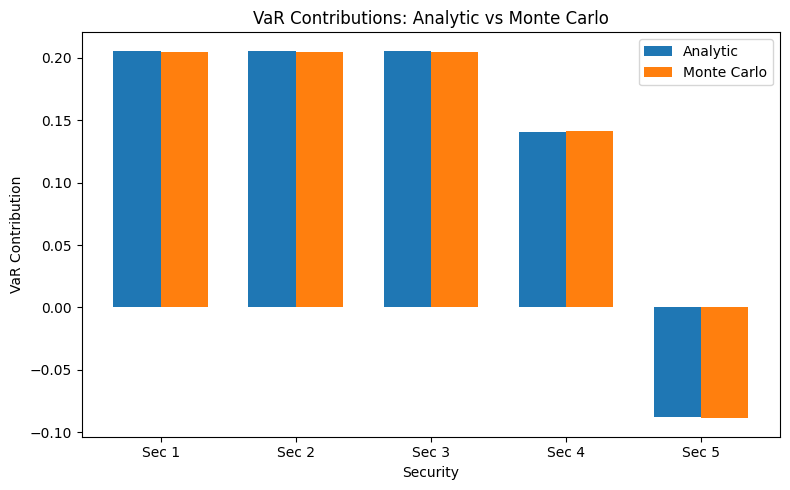

In [4]:
# Setup portfolio and compute contributions

# Portfolio size
n = 5
# Define target correlations:
rho_p = 0.3   # target positive correlation for group 1 (securities 0,1,2)
rho_n = -0.2  # target negative correlation for security 5 with others
n_sim=100000
seed = 44
alpha = 0.95

# Construct the off-diagonal matrix A_off using our specification
A_off = construct_A_off(n, rho_p, rho_n)

# Obtain the correlation matrix via the Archakov-Hansen algorithm
C = archakov_hansen_corr(A_off)
print("Correlation matrix C:")
print(np.round(C, 3))

# Assume unit volatilities so that covariance Sigma = C
Sigma = C.copy()

# Define portfolio weights (e.g., equal weights)
w = np.ones(n) / n

# Compute analytic VaR contributions
var_analytic, contrib_analytic = analytic_var_contributions(w, Sigma, alpha)
print("\nAnalytic portfolio VaR: {:.4f}".format(var_analytic))
print("Analytic VaR contributions:")
for i, c in enumerate(contrib_analytic):
    print("  Security {}: {:.4f}".format(i+1, c))

# Compute Monte Carlo VaR contributions
var_mc, contrib_mc = monte_carlo_var_contributions(w, Sigma, alpha, n_sim=n_sim, seed=seed)
print("\nMonte Carlo portfolio VaR: {:.4f}".format(var_mc))
print("Monte Carlo VaR contributions:")
for i, c in enumerate(contrib_mc):
    print("  Security {}: {:.4f}".format(i+1, c))

# Plot 
indices = np.arange(n)
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bar1 = ax.bar(indices - width/2, contrib_analytic, width, label='Analytic')
bar2 = ax.bar(indices + width/2, contrib_mc, width, label='Monte Carlo')

ax.set_xlabel('Security')
ax.set_ylabel('VaR Contribution')
ax.set_title('VaR Contributions: Analytic vs Monte Carlo')
ax.set_xticks(indices)
ax.set_xticklabels([f'Sec {i+1}' for i in indices])
ax.legend()
plt.tight_layout()
plt.show()


## Question 4

The function `optimize_portfolio` simulates $M$ return scenarios and then sets up a CVaR constraint using the Rockafellar–Uryasev linear formulation. The variable `tau` represents the VaR and `z` the slack for excess losses. The optimization maximizes the portfolio’s expected return  
$$
w^\top \mu + \Bigl(1-\sum_{i=1}^{N}w_i\Bigr)r_T,
$$
subject to the CVaR constraint being no more than `50%`. In part a+b we impose $w \ge 0$ and \$sum w \le 1$ (no short sales and no borrowing), while in part (c) we remove the no‑short-sale constraint. For various values of $M$ (the number of simulated scenarios used in the optimization), we solve for the portfolio and then use a large simulation sample (here, $M_{\text{sim\_eval}}=100000$) to re‑estimate the portfolio’s `95%` CVaR. Comparing the estimated CVaR to the `50%` target shows the bias as a function of $M$.

=== Optimization with No Short Sales on Risky Assets ===
M_sample = 500:
  Optimal risky weights: [-0.      0.      0.      0.      0.      0.2302  0.2043  0.1204  0.2382
  0.2069]
  Expected portfolio return: 0.2
  Estimated CVaR (95%): 0.2131
  CVaR Target: 0.50
  CVaR Bias: -0.2869

M_sample = 1000:
  Optimal risky weights: [0.     0.     0.     0.     0.     0.2279 0.2057 0.2103 0.176  0.18  ]
  Expected portfolio return: 0.2
  Estimated CVaR (95%): 0.2081
  CVaR Target: 0.50
  CVaR Bias: -0.2919

M_sample = 5000:
  Optimal risky weights: [-0.     -0.      0.      0.     -0.      0.1961  0.1833  0.1991  0.2245
  0.1969]
  Expected portfolio return: 0.2
  Estimated CVaR (95%): 0.2102
  CVaR Target: 0.50
  CVaR Bias: -0.2898

M_sample = 10000:
  Optimal risky weights: [-0.      0.      0.     -0.      0.      0.218   0.1892  0.2022  0.2004
  0.1901]
  Expected portfolio return: 0.2
  Estimated CVaR (95%): 0.2121
  CVaR Target: 0.50
  CVaR Bias: -0.2879

=== Optimization Allowing Shor

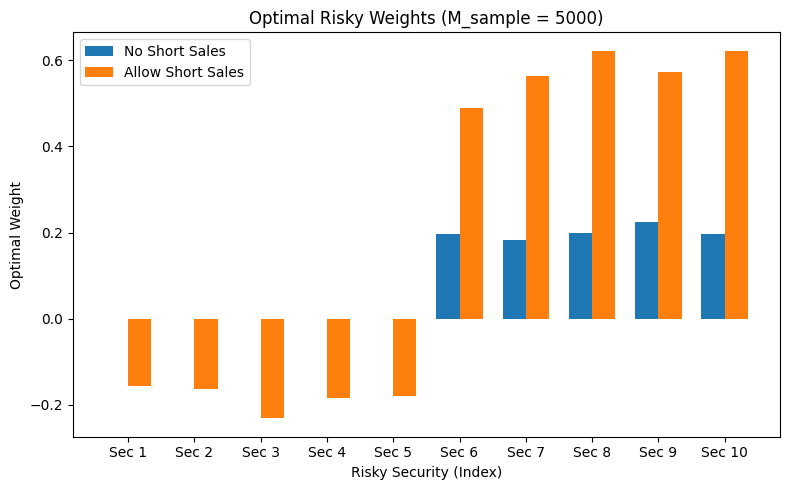

In [ ]:
def simulate_returns(M, mu, Sigma):
    """
    Simulate M sample vectors R ~ MVN(mu, Sigma)
    """
    return np.random.multivariate_normal(mu, Sigma, size=M)

def optimize_portfolio(M_sample, allow_short, CVaR_target, alpha_level):
    """
    Simulate M_sample scenarios for the risky returns,
    then solve for the portfolio (risky weights w) that maximizes expected portfolio return 
    subject to CVaR_{alpha_level} (on losses) <= CVaR_target.
    
    The overall portfolio return is
       r_p = w^T R + (1 - sum(w)) * r_T.
       
    In part (a)/(b) we require w >= 0 and 1-sum(w) >= 0 (i.e. no short-selling and no borrowing).
    In part (c) we allow negative w (risky short-selling) and allow borrowing (risk-free weight can be negative).
    
    Returns:
      w_opt: optimal risky weights (vector of length N)
      obj_value: achieved expected portfolio return (using sample average, computed as 
                 w^T (sample mean of R) + (1 - sum(w))*r_T)
      cvx_status: status of the optimization.
      problem: the cvxpy Problem object.
    """
    # Simulate M_sample scenarios for risky returns
    R_samples = simulate_returns(M_sample, mu, Sigma)  # shape: (M_sample, N)
    
    # Decision variable: weights on risky assets
    w = cp.Variable(N)
    # The weight on the risk-free asset is 1 - sum(w)
    
    # For each scenario m, portfolio return = w^T R_m + (1-sum(w))*r_T.
    portfolio_returns = R_samples @ w + (1 - cp.sum(w)) * r_T
    # Define loss as negative portfolio return.
    L = - portfolio_returns
    
    # CVaR formulation: introduce auxiliary variable tau and slack variables z_m for each scenario.
    tau = cp.Variable()
    z = cp.Variable(M_sample)
    
    # Constraints for slack variables: z_m >= L_m - tau, z_m >= 0.
    constraints = [z >= L - tau,
                   z >= 0]
    
    # CVaR constraint: tau + (1/(1-alpha_level))*(1/M_sample)*sum(z) <= CVaR_target.
    constraints += [tau + (1/(1 - alpha_level))*(cp.sum(z)/M_sample) <= CVaR_target]
    
    # Weight constraints:
    if not allow_short:
        # No short-sales in risky assets and no borrowing: w >= 0 and risk-free weight = 1 - sum(w) >= 0.
        constraints += [w >= 0, cp.sum(w) <= 1]
    
    # Objective: maximize expected portfolio return (using sample average or using mu).
    # Here we use the known parameters: expected return = w^T mu + (1 - sum(w))*r_T.
    objective = cp.Maximize( w @ mu + (1 - cp.sum(w)) * r_T )
    
    prob = cp.Problem(objective, constraints)
    prob.solve(solver=cp.SCS)
    
    return w.value, (w.value @ mu + (1 - np.sum(w.value))*r_T), prob.status, R_samples

# Function to estimate portfolio CVaR using a large simulation sample
def estimate_portfolio_CVaR(w, R_samples_eval, r_T, alpha_level):
    """
    Given portfolio weights w (on risky assets), and a matrix of simulated risky returns,
    compute the portfolio return r_p = w^T R + (1-sum(w))*r_T and estimate CVaR_{alpha_level}
    using the sample average of the worst (1-alpha_level) fraction of losses.
    
    Returns the estimated CVaR.
    """
    port_returns = R_samples_eval @ w + (1 - np.sum(w)) * r_T
    losses = -port_returns
    VaR = np.quantile(losses, alpha_level)
    # CVaR is the average loss in the tail (losses above VaR)
    CVaR_est = np.mean(losses[losses >= VaR])
    return CVaR_est

# Run optimization and bias investigation for a given M_sample
def run_experiment(M_sample, allow_short, CVaR_target, alpha_level):
    """
    Solve for the optimal portfolio with M_sample simulated scenarios.
    Then simulate a large evaluation sample to estimate the actual CVaR.
    Returns:
      w_opt, expected return, estimated CVaR.
    """
    w_opt, exp_ret, status, _ = optimize_portfolio(M_sample, allow_short=allow_short, CVaR_target=CVaR_target, alpha_level=alpha_level,)
    # Use a large number of simulations to evaluate the actual CVaR.
    R_samples_eval = simulate_returns(M_sim_eval, mu, Sigma)
    CVaR_est = estimate_portfolio_CVaR(w_opt, R_samples_eval, r_T, alpha_level=alpha_level)
    return w_opt, exp_ret, CVaR_est

# Parameters
N = 10                     # number of risky securities
T = 0.5                    # time horizon in years
r_annual = 0.03            # annual continuously compounded risk-free rate
r_T = r_annual * T         # log risk-free return over T (approximation)
M_sim_eval = 100000        # number of simulations for evaluating CVaR
CVaR_target = 0.50         # target CVaR level
alpha_level = 0.95         # confidence level for CVaR

# Construct mean vector and covariance matrix for the risky assets.
mu = np.array([0.10]* (N//2) + [0.20]* (N - N//2))   # first half 10%, second half 20%
sigma = 0.30
var = sigma**2
# Off-diagonals: correlation 0.3 so covariance = 0.3*0.3*0.3 = 0.027
corr = 0.3
Sigma = np.full((N, N), corr * sigma * sigma)
np.fill_diagonal(Sigma, var)



# Part (a) and (b): No short-selling on risky assets.
np.random.seed(123)
M_values = [500, 1000, 5000, 10000]  # different numbers of scenarios for the optimization sample
results_no_short = {}

print("=== Optimization with No Short Sales on Risky Assets ===")
for M_sample in M_values:
    w_opt, exp_ret, CVaR_est = run_experiment(M_sample, allow_short=False, CVaR_target=CVaR_target, alpha_level=alpha_level)
    results_no_short[M_sample] = (w_opt, exp_ret, CVaR_est)
    print(f"M_sample = {M_sample}:")
    print("  Optimal risky weights:", np.round(w_opt, 4))
    print("  Expected portfolio return:", round(exp_ret, 4))
    print("  Estimated CVaR (95%):", round(CVaR_est, 4))
    print("  CVaR Target: 0.50")
    print("  CVaR Bias: {:.4f}\n".format(CVaR_est - 0.50))

# Part (c): Allow short-sales (no nonnegativity on risky weights)
results_short = {}
print("=== Optimization Allowing Short Sales on Risky Assets ===")
for M_sample in M_values:
    w_opt, exp_ret, CVaR_est = run_experiment(M_sample, allow_short=True, CVaR_target=CVaR_target, alpha_level=alpha_level)
    results_short[M_sample] = (w_opt, exp_ret, CVaR_est)
    print(f"M_sample = {M_sample}:")
    print("  Optimal risky weights:", np.round(w_opt, 4))
    print("  Expected portfolio return:", round(exp_ret, 4))
    print("  Estimated CVaR (95%):", round(CVaR_est, 4))
    print("  CVaR Target: 0.50")
    print("  CVaR Bias: {:.4f}\n".format(CVaR_est - 0.50))

# For one chosen M_sample, compare optimal weights for the two cases.
M_plot = 5000
w_no_short, exp_ret_no_short, CVaR_no_short = results_no_short[M_plot]
w_short, exp_ret_short, CVaR_short = results_short[M_plot]

indices = np.arange(N)
width = 0.35
plt.figure(figsize=(8,5))
plt.bar(indices - width/2, w_no_short, width, label='No Short Sales')
plt.bar(indices + width/2, w_short, width, label='Allow Short Sales')
plt.xlabel('Risky Security (Index)')
plt.ylabel('Optimal Weight')
plt.title(f'Optimal Risky Weights (M_sample = {M_plot})')
plt.xticks(indices, [f'Sec {i+1}' for i in indices])
plt.legend()
plt.tight_layout()
plt.show()


#### Estimation Error Impact
Estimation error in the simulated return distribution can have a significant impact on the portfolio chosen in both cases. 
When the sample size M is small, the optimized portfolio may exploit noise in the CVaR constraint, 
leading to portfolios that in out-of-sample evaluation violate the intended CVaR threshold (i.e. the estimated CVaR is biased).
In the case with short-sales allowed, the optimizer may take extreme positions (long/short) to artificially lower the sample CVaR. 
In contrast, imposing no-short-sale constraints tends to provide more stable and robust portfolios. 
Overall, estimation error may result in "portfolios that are overly aggressive in their expected return but underestimate tail risk.
